### MSDS Deep Learning Week 5: Building and training generative deep learning models (mostly GAN)t
For this week's mini-project, we participate in one of the Kaggle competitions: 

Monet Painting Dataset (New) : https://www.kaggle.com/competitions/gan-getting-started

Generative Dog Images Dataset (Old) : https://www.kaggle.com/competitions/gan-getting-started/overview

We will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN).
Kaggle introduces an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images. Please have a close look at their explanation here: https://www.kaggle.com/c/gan-getting-started/overview/evaluation 

#### Import required libraries and dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
#import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


###### Connect to a TPU (Tensor Processing Unit) and initialize it for use with TensorFlow. If it fails to connect to the TPU, then fall back to using the default strategy. Set the value of AUTOTUNE to tf.data.experimental.AUTOTUNE and print the TensorFlow version

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Machine:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Replicas: 1
2.11.0


#### EDA

##### Get the Google Cloud Storage (GCS) path of a dataset. Use tf.io.gfile.glob function to find all the TFRecord files in the monet_tfrec and photo_tfrec directories and stores their file names in the MONET_FILES and PIC_FILES variables respectively. Then print the number of files found in each directory

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet Files:', len(MONET_FILES))

PIC_FILES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Picture Files:', len(PIC_FILES))

Monet Files: 5
Picture Files: 20


##### Decode format and converts to a tensor of type tf.float32. Rescale pixel values from the range [0, 255] to the range [-1, 1]. 
##### Define a dictionary that describes the features that should be extracted. 
##### The tf.io.parse_single_example function is used to parse the example and extract the features.
##### The image feature is then passed to the decode_image function to be decoded and returned.

In [4]:
PIC_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*PIC_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

##### Create a tf.data.TFRecordDataset from filenames and then apply the read_tfrecord function to each example in the dataset using the map method. The num_parallel_calls argument is set to AUTOTUNE to allow TensorFlow to choose the optimal number of parallel calls.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

##### Create datasets: monet_dataset and pic_dataset.

In [6]:
monet_dataset = load_dataset(MONET_FILES, labeled=True).batch(1)
pic_dataset = load_dataset(PIC_FILES, labeled=True).batch(1)

##### Extract the first element from monet_dataset and pic_dataset

In [7]:
first_monet = next(iter(monet_dataset))
first_pic = next(iter(pic_dataset))

##### Display the images.

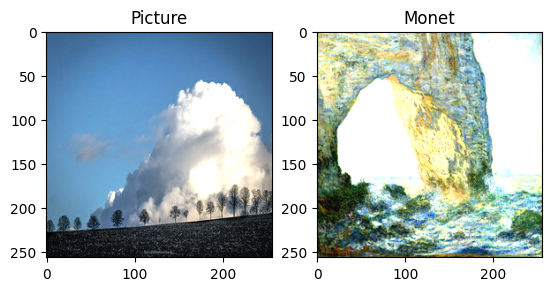

In [8]:
plt.subplot(121)
plt.title('Picture')
plt.imshow(first_pic[0] * 0.7 + 0.7)

plt.subplot(122)
plt.title('Monet')
plt.imshow(first_monet[0] * 0.7 + 0.7)

#### Model Building

##### Define downsample function that takes as input the number of filters, the kernel size, and an optional argument apply_instancenorm that specifies whether instance normalization should be applied. This function creates a Sequential model and adds a Conv2D layer with the specified number of filters and kernel size. The stride is set to 2 and the padding is set to ‘same’. If apply_instancenorm is True, an InstanceNormalization layer is added to the model. Finally, a LeakyReLU activation function is added to the model and the resulting model is returned.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

##### Define function upsample that takes as input the number of filters, the kernel size, and an optional argument apply_dropout that specifies whether dropout should be applied. The function creates a Sequential model and adds a Conv2DTranspose layer with the specified number of filters and kernel size. The stride is set to 2 and the padding is set to ‘same’. An InstanceNormalization layer is then added to the model. If apply_dropout is True, a Dropout layer with a rate of 0.5 is added to the model. Finally, a ReLU activation function is added to the model and the resulting model is returned.

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

##### Define Generator function to create a keras.Model representing a generator network. The function first defines an input layer with the shape [256, 256, 3]. It then creates two lists of layers: down_stack and up_stack. The down_stack list contains several downsample layers with different numbers of filters. The up_stack list contains several upsample layers with different numbers of filters and dropout options.

##### The function then creates a variable x and sets its value to the input layer. It also creates an empty list skips. The function then iterates over the layers in the down_stack list, applies each layer to x, and appends the result to the skips list. The skips list is then reversed and all but the last element are kept.

##### The function then iterates over the layers in the up_stack list and the elements in the skips list simultaneously using the zip function. In each iteration, it applies the current upsample layer to x, concatenates the result with the current skip element along the last axis using a Concatenate layer, and updates the value of x.

##### Finally, a Conv2DTranspose layer with the specified number of output channels is applied to x, followed by a hyperbolic tangent activation function. The resulting model takes an image as input and produces an image as output.

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

##### Define a Discriminator function that creates a keras.Model representing a discriminator network. The function first defines an input layer with the shape [256, 256, 3]. It then creates several layers, including three downsample layers with different numbers of filters, two ZeroPadding2D layers, two Conv2D layers with different numbers of filters and strides, an InstanceNormalization layer, and a LeakyReLU activation function.

##### The function applies these layers to the input in sequence. The output of the last layer is a tensor with shape [batch_size, 30, 30, 1]. The resulting model takes an image as input and produces a tensor representing the probability that the image is real (as opposed to being generated by the generator).

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

##### Create four models: monet_generator, pic_generator, monet_discriminator, and pic_discriminator. The models are created using the previously defined Generator and Discriminator functions. The monet_generator and pic_generator models are generators that transform photos to paintings similar to Monet and Monet paintings to be more like pictures, respectively. 
##### The monet_discriminator and pic_discriminator models are discriminators that differentiate real Monet paintings and generated Monet paintings, and real photos and generated photos, respectively.

##### The models are created within a strategy.scope() context to ensure that they are properly distributed across the available devices when using a distribution strategy such as TPUStrategy

In [13]:
with strategy.scope():
    monet_generator = Generator() 
    pic_generator = Generator()

    monet_discriminator = Discriminator()
    pic_discriminator = Discriminator() 


Transform the image stored in the example_photo variable into a Monet-esque painting. The transformed image is stored in the to_monet variable. The code then uses the matplotlib library to display the original and transformed images side by side. The subplot function is used to create two subplots, one for each image. The title function is used to set the title of each subplot. The imshow function is used to display the images. Since the pixel values of the images are in the range [-1, 1], they are rescaled to the range [0, 1] before being displayed.

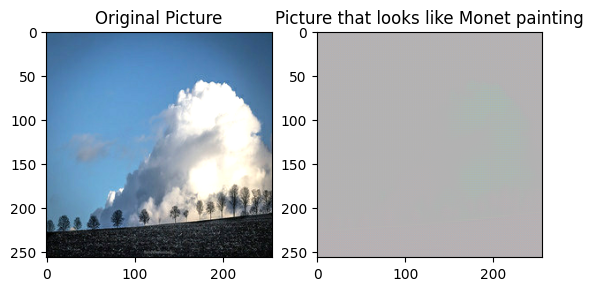

In [14]:
k = monet_generator(first_pic)

plt.subplot(1, 2, 1)
plt.title("Original Picture")
plt.imshow(first_pic[0] * 0.7 + 0.7)

plt.subplot(1, 2, 2)
plt.title("Picture that looks like Monet painting")
plt.imshow(k[0] * 0.7 + 0.7)
plt.show()

##### Build Cycle GAN Model

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
     
        

##### Define Loss Fucntions

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    pic_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    pic_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, pic_generator, monet_discriminator, pic_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = pic_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = pic_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, pic_dataset)),
    epochs=11
)


Epoch 1/11
300/300 [==============================] - 1548s 5s/step - monet_gen_loss: 5.1538 - photo_gen_loss: 5.3762 - monet_disc_loss: 0.6691 - photo_disc_loss: 0.6237
Epoch 2/11
300/300 [==============================] - 1492s 5s/step - monet_gen_loss: 3.6014 - photo_gen_loss: 3.7196 - monet_disc_loss: 0.6663 - photo_disc_loss: 0.6335
Epoch 3/11
300/300 [==============================] - 1491s 5s/step - monet_gen_loss: 3.5036 - photo_gen_loss: 3.6385 - monet_disc_loss: 0.6542 - photo_disc_loss: 0.6267
Epoch 4/11
300/300 [==============================] - 1469s 5s/step - monet_gen_loss: 3.3845 - photo_gen_loss: 3.5087 - monet_disc_loss: 0.6467 - photo_disc_loss: 0.6160
Epoch 5/11
300/300 [==============================] - 1480s 5s/step - monet_gen_loss: 3.2503 - photo_gen_loss: 3.3913 - monet_disc_loss: 0.6362 - photo_disc_loss: 0.6007
Epoch 6/11
300/300 [==============================] - 1476s 5s/step - monet_gen_loss: 3.1778 - photo_gen_loss: 3.2805 - monet_disc_loss: 0.6268 - phot

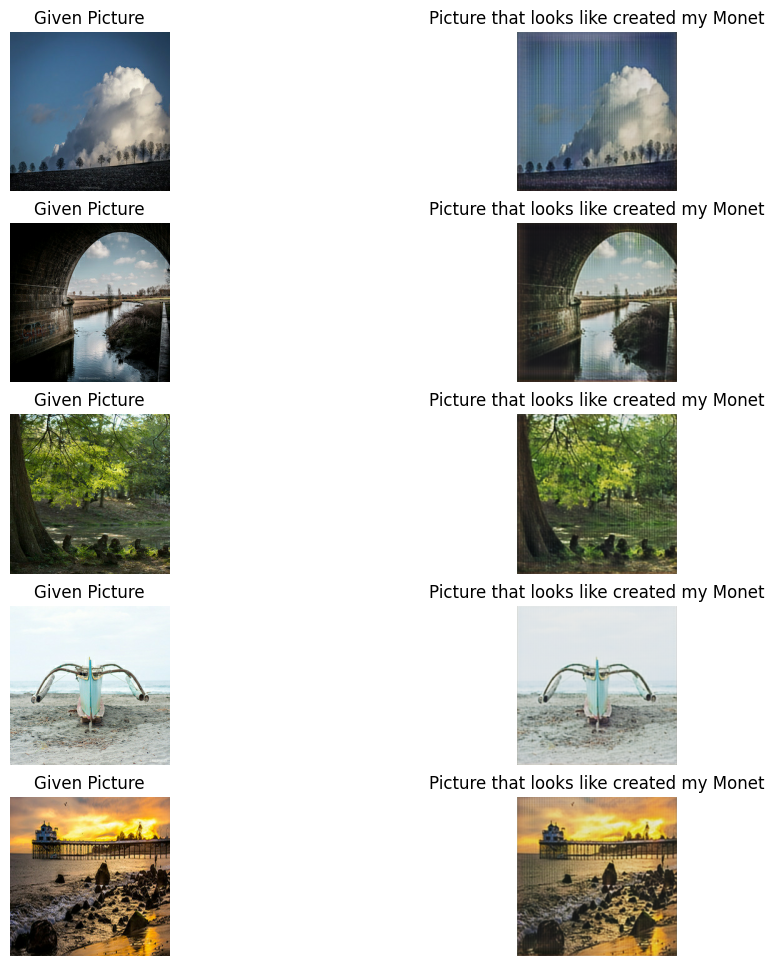

In [23]:
_, a = plt.subplots(5, 2, figsize=(12, 12))
for i, j in enumerate(pic_dataset.take(5)):
    predict = monet_generator(j, training=False)[0].numpy()
    predict = (predict * 127.5 + 127.5).astype(np.uint8)
    j = (j[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    a[i, 0].imshow(j)
    a[i, 1].imshow(predict)
    a[i, 0].set_title("Given Picture")
    a[i, 1].set_title("Picture that looks like created my Monet")
    a[i, 0].axis("off")
    a[i, 1].axis("off")
plt.show()

In [24]:
import PIL
! mkdir /kaggle/working/images

mkdir: cannot create directory ‘/kaggle/working/images’: File exists


In [25]:
i = 1
for img in pic_dataset:
    predict = monet_generator(img, training=False)[0].numpy()
    predict = (predict * 127.5 + 127.5).astype(np.uint8)
    j = PIL.Image.fromarray(predict)
    j.save("/kaggle/working/images/" + str(i) + ".jpg")
    #print(i)
    i += 1

In [1]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'